# Capstone - Respiratory Data Analysis - Machine Learning approach

This notebook provides implementation and evaluation of different Machine Learning (ML) models and evaluation for Respiratory Data Analysis multi-class classification.

In [1]:
dataset_export_path='/Users/famillenassivet/Documents/bruno/Certifications/coursera/Data Science/Capstone/dataset/Respiratory_dataset/respiratory-sound-database-export/export/'
data_path=dataset_export_path+"respiratoryDataAugmented_v1.2"

In [2]:
import findspark
findspark.init()
import pyspark

In [3]:
sc = pyspark.SparkContext(appName="RespiratoryDataAnalysisModelML",
                         master="local[2]").getOrCreate()
sc

<SparkContext master=local[2] appName=RespiratoryDataAnalysisModelML>

In [4]:
from pyspark import SQLContext
sql_c = SQLContext(sc)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
diagnosisList = ['COPD','Healthy','URTI','Bronchiectasis','Bronchiolitis','Pneumonia','LRTI','Asthma']

In [7]:
from pyspark.sql import DataFrameReader
data_df = sql_c.read.json(path=data_path)

In [8]:
data_df.dtypes

[('_1', 'string'),
 ('_2', 'bigint'),
 ('_3', 'double'),
 ('_4', 'double'),
 ('_5', 'bigint'),
 ('_6', 'array<array<double>>')]

In [9]:
data_df.repartition(2)

DataFrame[_1: string, _2: bigint, _3: double, _4: double, _5: bigint, _6: array<array<double>>]

In [10]:
data_df = data_df.withColumnRenamed('_1', 'file_name')\
        .withColumnRenamed('_2', 'sampleId')\
        .withColumnRenamed('_3', 'patientId')\
        .withColumnRenamed('_4', 'diagIndex')\
        .withColumnRenamed('_5', 'recSource')\
        .withColumnRenamed('_6', 'mfcc')



In [11]:
data_df = data_df.withColumnRenamed('diagIndex', 'label')

In [12]:
from pyspark.sql import functions
data_df = data_df.withColumn('feature',functions.flatten(data_df.mfcc))

In [13]:
data_df.show(1)

+--------------------+--------+---------+-----+---------+--------------------+--------------------+
|           file_name|sampleId|patientId|label|recSource|                mfcc|             feature|
+--------------------+--------+---------+-----+---------+--------------------+--------------------+
|200_2p2_Ar_mc_AKG...|       6|    200.0|  0.0|        2|[[-198.7150412270...|[-198.71504122702...|
+--------------------+--------+---------+-----+---------+--------------------+--------------------+
only showing top 1 row



In [14]:
data_df.dtypes

[('file_name', 'string'),
 ('sampleId', 'bigint'),
 ('patientId', 'double'),
 ('label', 'double'),
 ('recSource', 'bigint'),
 ('mfcc', 'array<array<double>>'),
 ('feature', 'array<double>')]

In [15]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

data_df = data_df.withColumn("features", to_vector("feature"))

In [16]:
data_df.dtypes

[('file_name', 'string'),
 ('sampleId', 'bigint'),
 ('patientId', 'double'),
 ('label', 'double'),
 ('recSource', 'bigint'),
 ('mfcc', 'array<array<double>>'),
 ('feature', 'array<double>'),
 ('features', 'vector')]

In [17]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
#train, test = data_df.randomSplit([0.7, 0.3], seed=12345)
train = data_df.filter(data_df.recSource=='2')
test = data_df.filter(data_df.recSource=='1')

In [18]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Normalizer

In [19]:
encoder = OneHotEncoder(inputCol='label', outputCol='labelVec')

In [20]:
#vectorAssembler = VectorAssembler(inputCols=["feature"],
#                                 outputCol="features")

In [21]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10)

## Classification using RandomForest classifier

In [22]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=8, maxDepth=4, labelCol="label", seed=42)

In [23]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = [encoder, rf])

In [24]:
model = pipeline.fit(train)

In [25]:
rf_train_pred = model.transform(train)

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")
binEval.evaluate(rf_train_pred)

0.683974358974359

In [27]:
rf_test_pred = model.transform(test)

In [28]:
binEval.evaluate(rf_test_pred)

0.5067264573991032

In [29]:
rf_test_pred.select('patientId','label','probability','prediction').show(5)

+---------+-----+--------------------+----------+
|patientId|label|         probability|prediction|
+---------+-----+--------------------+----------+
|    145.0|  0.0|[0.11861532296493...|       3.0|
|    172.0|  0.0|[0.55598952910265...|       0.0|
|    175.0|  0.0|[0.07682152905574...|       2.0|
|    154.0|  0.0|[0.18692799838356...|       3.0|
|    151.0|  0.0|[0.52413467746548...|       0.0|
+---------+-----+--------------------+----------+
only showing top 5 rows



In [30]:
from pyspark.mllib.evaluation import MulticlassMetrics
prediction_and_label = sql_c.createDataFrame(rf_test_pred.select('prediction', 'label').rdd)
metrics = MulticlassMetrics(prediction_and_label.rdd)

In [31]:
metrics.accuracy

0.5067264573991032

In [32]:
metrics.confusionMatrix().toArray()

array([[140.,   3.,   9.,  14.,  11.,  17.,   5.,   0.],
       [  5.,   6.,  17.,   9.,   7.,  18.,   7.,   0.],
       [  5.,   0.,  19.,   7.,   4.,   4.,   6.,   0.],
       [  0.,   0.,   1.,  22.,   4.,   3.,   1.,   0.],
       [  1.,   3.,  10.,   2.,   3.,   2.,   4.,   0.],
       [  2.,   4.,  10.,   6.,   4.,  35.,  12.,   0.],
       [  0.,   0.,   2.,   0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]])

In [33]:
print(metrics.precision())
print(metrics.recall())

0.5067264573991032
0.5067264573991032


In [34]:
metrics.weightedTruePositiveRate, metrics.weightedFalsePositiveRate

(0.5067264573991032, 0.0705531250692538)

In [35]:
#from pyspark.mllib.tree import GradientBoostedTrees
#gbtModel = GradientBoostedTrees.trainClassifier(data_df, {}, numIterations=10)
#gbtModel.numTrees()
#gbtPipeline = Pipeline(stages = [encoder, gbtModel])

In [36]:
def plot_confusion_matrix(confm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix cm.
    Normalization can be applied by setting `normalize=True`.
    """
    #from sklearn.metrics import confusion_matrix
    #from sklearn.utils.multiclass import unique_labels
    from matplotlib.pyplot import cm
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    confm=np.asarray(confm)
    # Compute confusion matrix
    #cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        confm = confm.astype('float') / confm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        confm = confm.astype('int')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(confm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(confm.shape[1]),
           yticks=np.arange(confm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = confm.max() / 2.
    for i in range(confm.shape[0]):
        for j in range(confm.shape[1]):
            ax.text(j, i, format(confm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if confm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


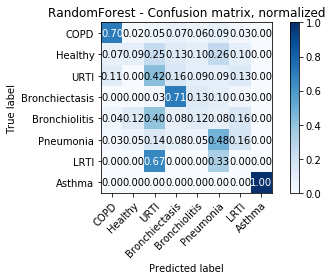

In [37]:
plot_confusion_matrix(confm=metrics.confusionMatrix().toArray(), 
                      classes=diagnosisList,
                      normalize=True,
                      title='RandomForest - Confusion matrix, normalized')



Confusion matrix, without normalization


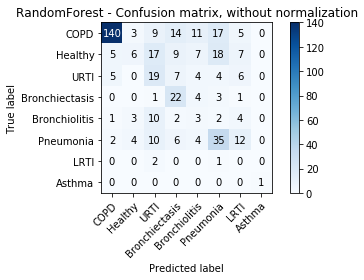

In [38]:
plot_confusion_matrix(confm=metrics.confusionMatrix().toArray(), 
                      classes=diagnosisList,
                      normalize=False,
                      title='RandomForest - Confusion matrix, without normalization')

### SVM using scikit-learn

In [39]:
data_df.dtypes

[('file_name', 'string'),
 ('sampleId', 'bigint'),
 ('patientId', 'double'),
 ('label', 'double'),
 ('recSource', 'bigint'),
 ('mfcc', 'array<array<double>>'),
 ('feature', 'array<double>'),
 ('features', 'vector')]

labels = data_df.select('label').rdd.map(lambda x : x.label).collect()
features = data_df.select('feature').rdd.map(lambda x : x.feature).collect()


import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(features, labels, test_size=0.2, random_state=32)

labels[0],features[0][0]

In [40]:
X_train = train.select(train.feature).rdd.map(lambda x : x.feature).collect()
Y_train = train.select(train.label).rdd.map(lambda x : x.label).collect()
X_test = test.select(test.feature).rdd.map(lambda x : x.feature).collect()
Y_test = test.select(test.label).rdd.map(lambda x : x.label).collect()

In [56]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', class_weight='balanced',kernel='poly',degree=8)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=8, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
clf.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=8, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
y_pred = clf.predict(X_test)

Accuracy score

In [58]:
from sklearn.metrics import accuracy_score
print("Accuracy : %.2f%%" % (accuracy_score(Y_test, y_pred)*100))

Accuracy : 74.44%


Classification report

In [59]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_pred)
print(report)

             precision    recall  f1-score   support

        0.0       0.87      0.90      0.89       199
        1.0       0.61      0.67      0.64        69
        2.0       0.50      0.42      0.46        45
        3.0       0.96      0.87      0.92        31
        4.0       0.43      0.52      0.47        25
        5.0       0.72      0.63      0.67        73
        6.0       0.00      0.00      0.00         3
        7.0       1.00      1.00      1.00         1

avg / total       0.74      0.74      0.74       446



In [60]:
def plot_sk_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax





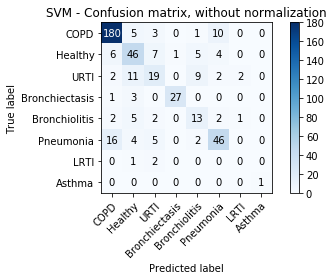

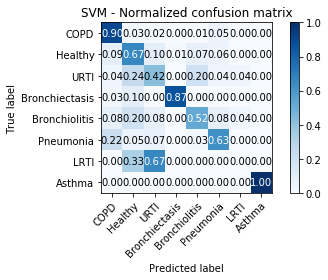

In [61]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_sk_confusion_matrix(Y_test, y_pred, classes=diagnosisList,
                      title='SVM - Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_sk_confusion_matrix(Y_test, y_pred, classes=diagnosisList, normalize=True,
                      title='SVM - Normalized confusion matrix')

plt.show()

In [62]:
plt.close()

In [69]:
from sklearn import svm
clf = svm.SVC(C=0.8, coef0=0.05, class_weight='balanced',kernel='poly',degree=8)

In [70]:
clf.fit(X_train, Y_train)

SVC(C=0.8, cache_size=200, class_weight='balanced', coef0=0.05,
  decision_function_shape='ovr', degree=8, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [71]:
y_pred = clf.predict(X_test)

In [72]:
from sklearn.metrics import accuracy_score
print("Accuracy : %.2f%%" % (accuracy_score(Y_test, y_pred)*100))

Accuracy : 74.44%


In [73]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_pred)
print(report)

             precision    recall  f1-score   support

        0.0       0.87      0.90      0.89       199
        1.0       0.61      0.67      0.64        69
        2.0       0.50      0.42      0.46        45
        3.0       0.96      0.87      0.92        31
        4.0       0.43      0.52      0.47        25
        5.0       0.72      0.63      0.67        73
        6.0       0.00      0.00      0.00         3
        7.0       1.00      1.00      1.00         1

avg / total       0.74      0.74      0.74       446



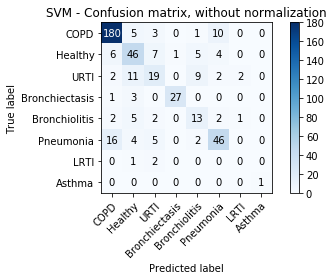

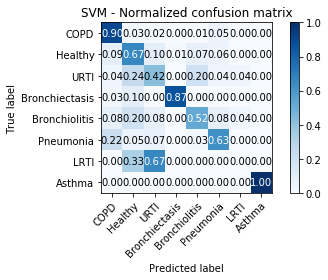

In [74]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_sk_confusion_matrix(Y_test, y_pred, classes=diagnosisList,
                      title='SVM - Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_sk_confusion_matrix(Y_test, y_pred, classes=diagnosisList, normalize=True,
                      title='SVM - Normalized confusion matrix')

plt.show()

In [48]:
sc.stop()